# 🧠🤖 Perceptron Multiclasse e Multilabel, Métricas e Funções de Ativação

O objetivo deste notebook é compreender: 
- Como implementar uma versão do Perceptron para tarefas multiclasse e multilabel. 
- Outras métricas de avaliação para tarefas de classificação (binária e multiclasse) e como elas se comparam com a acurácia. 
- Funções de ativação diferentes da função de limiar.

## Tarefas de Classificação Binária, Multiclasse e Multilabel

### 🎯 Classificação Binária

Nestas tarefas, uma amostra pode pertecer a uma dentre duas classes possíveis. Todas as tarefas que estudamos até agora são deste tipo. 

Podem ser utilizadas tanto quando a tarefa é decidir se um item pertence a uma classe ou não (e.g., "é um 7 ou não?"), quanto para distinguir entre duas classes possíveis (e.g., "o digito é 7 ou 9?").

Exemplos: 
- Dado um texto, decidir se ele é spam ou não. 
- Dado um exame, decidir se ele é saudável ou não. 
- Dada foto de um semáforo, decidir se o veículo pode prosseguir ou não.

### 🎯 Classificação Multiclasse 

São tarefas em que uma amostra pode ser classificada em uma dentre 3 ou mais classes possíveis. 

Exemplos:
- Dada a foto um digito manuscrito, definir qual é o digito dentre 0, 1, ..., 9.
- Dada a foto de uma lesão, definir qual é o tipo de lesão dentre um conjunto de possibilidades.

**Observação**: Note que apenas uma classe é atribuída a cada amostra.

Um conjunto de classificadores binários podem ser usados para atacar tarefas multiclasse. Neste caso, cada classificador afirma se a amostra é de uma classe específica ou não. Esta é a abordagem que utilizaremos para implementar o Perceptron multiclasse.

Um desafio nesta forma de modelar a solução é decidir o que fazer quando nenhum classificador binário "se ativar" ou quando mais de um classificador "se ativar". 
- Uma interpretação possível no caso de nenhuma ativação é que a amostra não é próxima o suficiente de nenhum padrão visto durante o treinamento. Uma resposta possível neste caso é responder que o modelo não sabe ou não é capaz de classificar a amostra.
- No caso de mais de uma ativação, temos que a amostra se parece com mais de um padrão visto durante o treinamento. Neste caso, podemos responder que o modelo "está em dúvida" e retornar as  possibilidades. Alternativamente, podemos escolher uma delas aleatoriamente e retornar como resposta.

Veremos mais à frente que funções de ativação podem ser utilizadas para introduzir um viés de como queremos interpretar as saídas do modelo e adicionar mecanismos que tornam uma ou outra interpretação mais natural. 


### 🎯 Classificação Multilabel 

Em tarefas multirótulo (*multilabel*, em inglês), exitem várias classes possíveis, como no caso das tarefas multiclasse, mas **uma amostra pode ser atribuída a mais de uma classe ao mesmo tempo**.

Exemplos: 
- Dado um artigo de jornal, atribuir todos os tópicos sobre os quais ele fala. O texto "A nova legislação sobre energias renováveis foi aprovada" contém os tópicos "meio ambiente", "política" e "energia".
- Identificar todos os objetos presentes em uma imagem dado um conjunto de objetos de interesse. Uma dada imagem, pode conter "carros", "pessoas" e "bicicletas".
- Dada uma música, definir os gêneros musicais nos quais ela se encaixa. Uma mesma música pode ter elementos de "rock alternativo" e "eletrônica".

Como no caso anterior, um conjunto de classificadores binários podem ser usados para abordar uma tarefa multilabel. Neste caso, se nenhum classificador "se ativa", temos que a amostra não possui nenhum dos rótulos de interesse e se mais de um classificador se ativa, assumimos que ela deve receber todos aqueles rótulos. 

**Importante**: Veja que conjuntos de classificadores binários podem ser utilizados tanto em tarefas multiclasse quanto multilabel, e o que muda entre os dois casos é a forma como interpretamos a saída dos classificadores.


## Perceptron Multiclasse e Multilabel

Para implementar uma versão do Perceptron capaz de lidar com tarefas multiclasse e multilabel, vamos usar um conjunto de classificadores binários similares àquele visto nas aulas anteriores.

Como indicado na imagem abaixo, todos os classificadores irão receber os mesmos dados como entrada, mas os pesos por neurônio podem ser diferentes. Cada neurônio se tornará "responsável" por um classe.

As operações serão modificadas da seguinte forma: 

- **forward**: a entrada é utilizada como entrada para todos os neurônios separadamente e a saída é o array com as saídas de todos os neurônios. 

- **treino**: cada amostra é usada para treinar todos os neurônios. Se a amostra é de uma dada classe, o respectivo neurônio será treinado para responder 1 os demais serão treinados para responder 0.


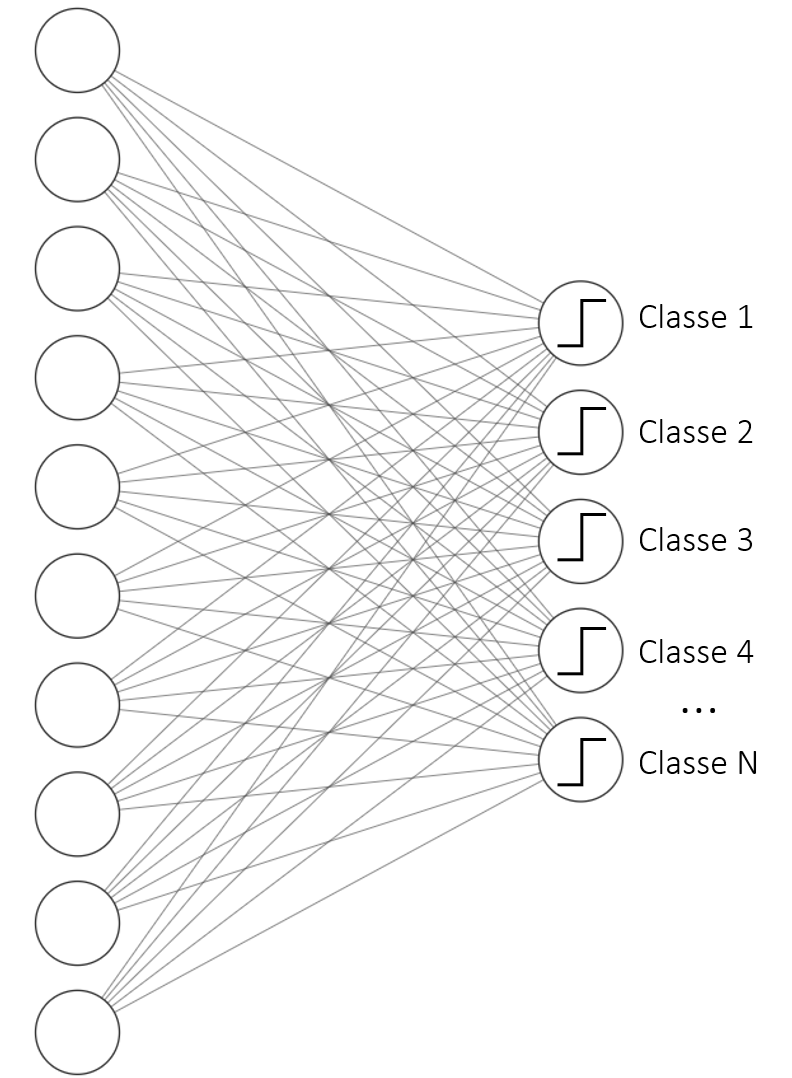

### Implementação do Perceptron Multiclass/Multilabel

A implementação mais ingênua seria criar uma classe `PerceptronNetwork` contendo uma lista de objetos do tipo `Perceptron` como implementados na aula passada. 

Contudo, vamos realizar uma implementação que se benefica mais de operações matriciais do `numpy`. 

$$
\mathbf{\mathit{y}} = \sigma \left( \mathbf{W} \mathbf{\mathit{x}} + \mathbf{\mathit{b}} \right)
$$

onde $\sigma$ é a função de ativação.


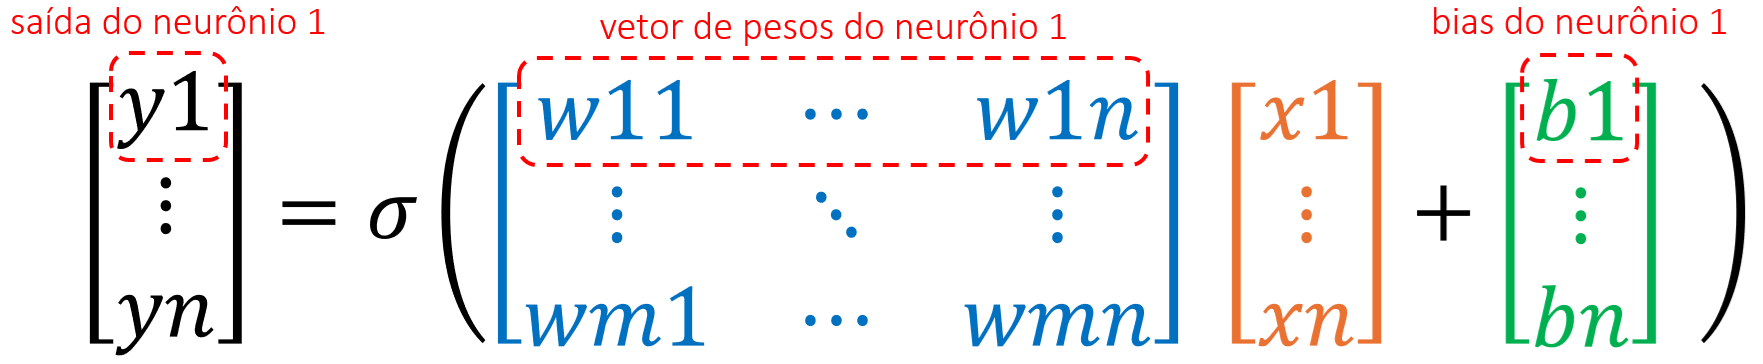

Nesta implementação, os métodos terão mais algumas modificações: 

- **construtor**: vai receber a matriz de pesos e o vetor de bias iniciais.

- **forward**: multiplicamos a matriz pela entrada, somamos o bias e aplicamos a função de ativação a todos os elementos. 

- **train**: para cada amostra do dataset, passamos a entrada pelos neurônios calculamos o erro assumindo saída esperada igual a 1 para o neurônio responsável pela classe e 0 para os demais. Portanto, todos os neurônios são treinados a cada passo, um deles para responder 1 ao receber a amostra e os outros para responder 0.

- **callback**: por simplicidade, vamos manter o callback por época apenas nesta implementação.


**Observações**: 

- Note que dada uma entrada, a saída será um vetor de 0s e 1s com o mesmo tamanho do número de classes.

- Esta arquitetura pode ser utilizada tanto para multiclass quanto para multilabel, bastante modificar quais neurônios serão treinados para responder 1 a cada amostra.

In [1]:

from collections.abc import Callable
import numpy as np

class PerceptronMulticlass:
    def __init__(self,
                 initial_weights: np.ndarray,
                 initial_bias: np.ndarray,
                 activation_fn):

        assert len(initial_weights.shape) == 2, "weights matrix should be n_classes x input_dim"
        assert len(initial_bias.shape) == 1, "bias should be a vector with size equals to the number of classes."

        self._weights = initial_weights
        self._bias = initial_bias
        self._activation_fn = activation_fn

    def forward(self, x: np.ndarray):
        z = np.matmul(self._weights, x) + self._bias
        o = self._activation_fn(z)
        return o

    def train(self, X: np.ndarray,
                    y: np.ndarray,
                    lr: float,
                    epochs: int,
                    callback: Callable = lambda a, b: None):

        n_samples, n_features = X.shape
        n_classes = self._weights.shape[0]

        for epoch_idx in range(epochs): # repeticao por um numero de epocas
            for x_i, y_i in zip(X, y): # iteracao pelas amostras do dataset
                # predicao da saida para a amostra x_i
                y_predicted = self.forward(x_i)

                for class_idx in range(n_classes):
                    expected = 1 if class_idx == y_i else 0

                    # calculo do erro
                    error = expected - y_predicted[class_idx]

                    if error != 0:
                        # atualizacao dos parametros
                        weight_update = lr * error * x_i
                        bias_update = lr * error

                        self._weights[class_idx, :] += weight_update
                        self._bias[class_idx] += bias_update

            callback(epoch_idx, self)

### Escolha da Classe de Saída no caso Multiclass

Vamos focar em tarefas multiclasse para realizar um exemplo de uso da rede neural.

Primeiro, vamos implementar uma função para decidir qual será a classe de saída considerando o fato que vários neurônios podem se ativar ou nenhum. 
- Nossa estratégia será retornar `-1` para indicar que a rede não sabe responder neste caso. 
- Se mais de um neurônio estiver ativado, vamos escolher uma classe aletoriamente. 

In [2]:

def sample_class(predictions):
    possible_answers = [i for i in range(len(predictions)) if predictions[i] == 1]
    if len(possible_answers) == 0:
        return -1
    return np.random.choice(possible_answers)


### Acurácia Multiclasse

Para calcular a taxa de acerto (acurácia) no caso multiclasse, vamos contar o percentual de amostras em que a classe de saída é igual ao esperado. 

Por exemplo, considere os valores abaixo: 

$$
true = [2, 7, 5, 2, 1, 1, 2, 3]
$$

$$
pred = [0, 7, 5, 1, 1, 0, 2, 3]
$$

São 8 amostras no total, 5 são iguais e 3 são diferentes, portanto, a acurácia será $5 / 8 = 62.5\% $.


In [3]:

def multiclass_accuracy(y_true, y_pred):
    n_acertos = np.sum(y_true == y_pred)
    acc = n_acertos / len(y_true)
    return acc


### Exemplo de Uso

Download da base de dados MNIST.

In [4]:
import matplotlib.pyplot
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
mnist_X = mnist.data.astype('float32')
mnist_y = mnist.target.astype('int64')
mnist_X /= 255.0

Abaixo é dada uma função útil para passar todas as amostras de um conjunto pela rede e predizer a classe.

In [5]:

def predict_for_set(X, model):
    predictions = [model.forward(sample) for sample in X]
    classes = [sample_class(c) for c in predictions]
    classes = np.array(classes)
    return classes


Abaixo é dada a classe de callback para mostrar a acurácia à cada época.

In [6]:

class MyCallback:
    """callback para mostrar acuracia a cada epoca"""
    def __init__(self, X, y, n_epochs):
        self._X = X
        self._y = y
        self._n_epochs = n_epochs

    def __call__(self, epoch_idx, model):
        preds = predict_for_set(self._X, model)
        acc = multiclass_accuracy(self._y, preds)
        print(f"Epoch: {epoch_idx} of {self._n_epochs} - Training Accuracy: {acc: .3f}")


Abaixo, vamos dividir os dados com conjuntos de treino e teste. Desta vez, vamos usar imagens de todos os digitos. 

**Observação**: A divisão abaixo utiliza todo o dataset e talvez demore um pouco para rodar. Se for este o caso, use, por exemplo, as imagens de 0 a 6000 para treinar e de 6000 a 7000 para teste.


In [7]:
train_X = mnist_X[:60000]
train_y = mnist_y[:60000]

test_X = mnist_X[60000:]
test_y = mnist_y[60000:]


Abaixo realizamos o treinamento do modelo.

In [8]:

weights = np.zeros((10, 784))
bias = np.zeros((10, ))

# funcao de ativacao
def threshold_fn(z):
    return np.where(np.asarray(z) >= 0, 1, 0)

model = PerceptronMulticlass(weights, bias, threshold_fn)

model.train(train_X, train_y, 0.1, 20, MyCallback(train_X, train_y, 20))

Epoch: 0 of 20 - Training Accuracy:  0.747
Epoch: 1 of 20 - Training Accuracy:  0.744
Epoch: 2 of 20 - Training Accuracy:  0.754
Epoch: 3 of 20 - Training Accuracy:  0.758
Epoch: 4 of 20 - Training Accuracy:  0.753
Epoch: 5 of 20 - Training Accuracy:  0.767
Epoch: 6 of 20 - Training Accuracy:  0.786
Epoch: 7 of 20 - Training Accuracy:  0.753
Epoch: 8 of 20 - Training Accuracy:  0.791
Epoch: 9 of 20 - Training Accuracy:  0.759
Epoch: 10 of 20 - Training Accuracy:  0.765
Epoch: 11 of 20 - Training Accuracy:  0.756
Epoch: 12 of 20 - Training Accuracy:  0.770
Epoch: 13 of 20 - Training Accuracy:  0.768
Epoch: 14 of 20 - Training Accuracy:  0.760
Epoch: 15 of 20 - Training Accuracy:  0.786
Epoch: 16 of 20 - Training Accuracy:  0.764
Epoch: 17 of 20 - Training Accuracy:  0.784
Epoch: 18 of 20 - Training Accuracy:  0.775
Epoch: 19 of 20 - Training Accuracy:  0.786


Abaixo, realizamos uma **análise quantitativa** da performance do modelo pelo cálculo da acurácia para o conjunto de teste.

In [9]:

preds = predict_for_set(test_X, model)
multiclass_accuracy(test_y, preds)


np.float64(0.7804)

A figura abaixo realiza uma **análise qualitativa** do comportamento do modelo para diferentes amostras. 

O objetivo desta análise é compreender os casos em que ele se comporta bem e os casos em que o modelo comete erros.

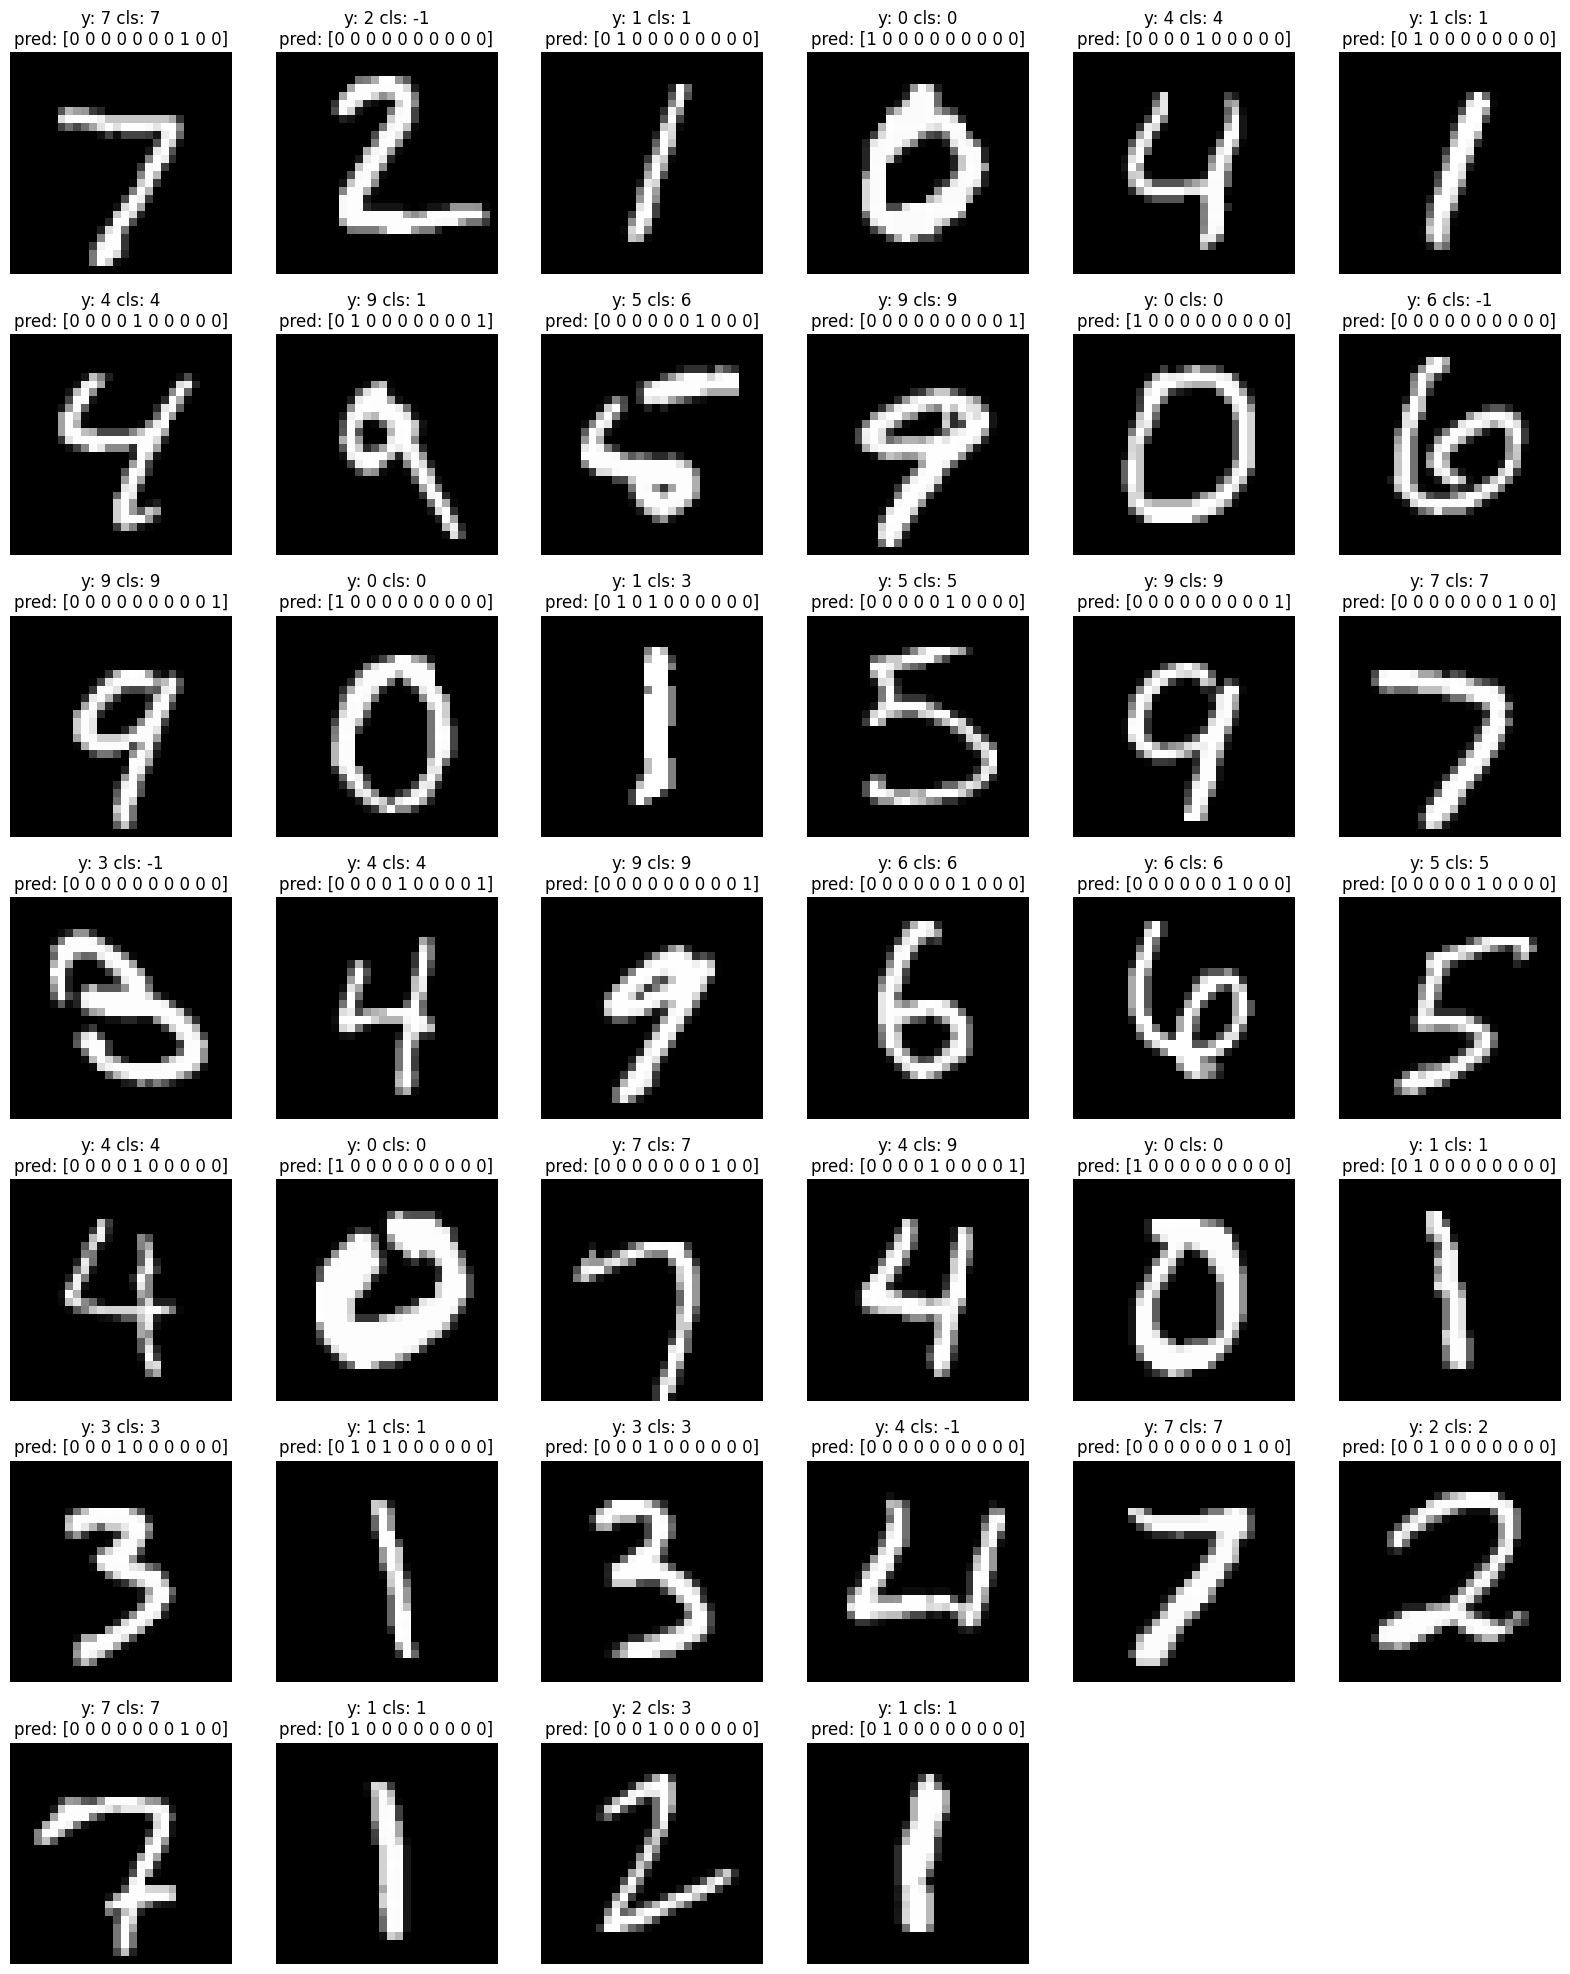

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 25))

for idx in range(40):
    plt.subplot(7, 6, idx+1)

    img = test_X[idx].reshape((28, 28))
    pred = model.forward(test_X[idx])
    cls = sample_class(pred)
    title = f"y: {test_y[idx]} cls: {cls}\npred: {pred}"

    plt.imshow(img, cmap='gray')
    plt.title(title)

    plt.axis('off')

plt.show()


Como na aula passada, podemos avaliar os pesos dos neurônios para tentar identificar padrões que permitam explicar como o modelo está tomando decisões.

Vamos utilizar desta vez o color map `'seismic'`, no qual pixels vermelho são positivos, isto é, "votam a favor" da classe e pixels azuis são negativos, isto é, "votam contra" a classe.

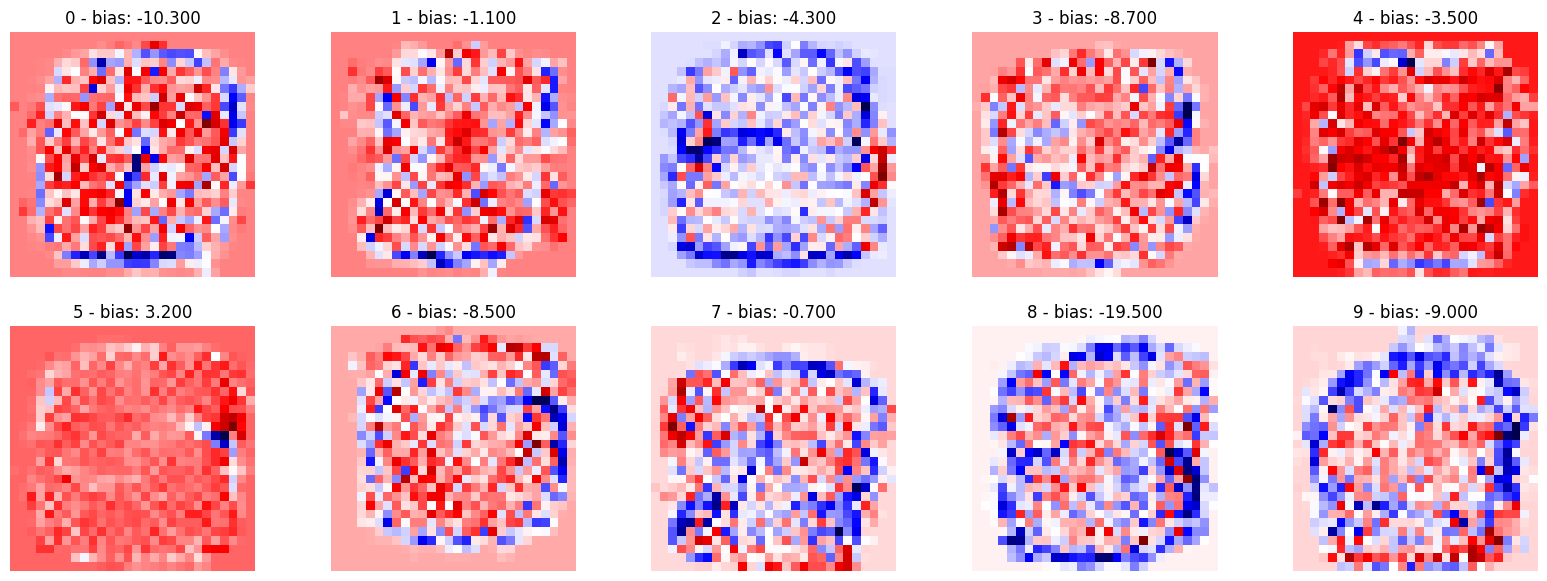

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

for idx in range(10):
    plt.subplot(2, 5, idx+1)
    img = model._weights[idx].reshape((28, 28))
    plt.imshow(img, cmap='seismic')
    plt.title(f"{idx} - bias: {model._bias[idx]:.3f}")
    plt.axis('off')

plt.show()

Para complementar esta análise, vamos comparar os pesos com as **imagens médias** dos digitos. 

Como as médias serão calculadas usando uma grande quantidade de imagens, vamos realizar a operação primeiro para não ser necessário recalcular várias vezes.

In [12]:
avg_imgs = []

for idx in range(10):
    img = np.mean(mnist_X[mnist_y == idx], axis=0)
    img = img.reshape((28, 28))
    avg_imgs.append(img)

avg_imgs = np.array(avg_imgs)
avg_imgs.shape

(10, 28, 28)

A seguir, seguem as imagens dos digitos médios. Compare as imagens com os imagens dos pesos.

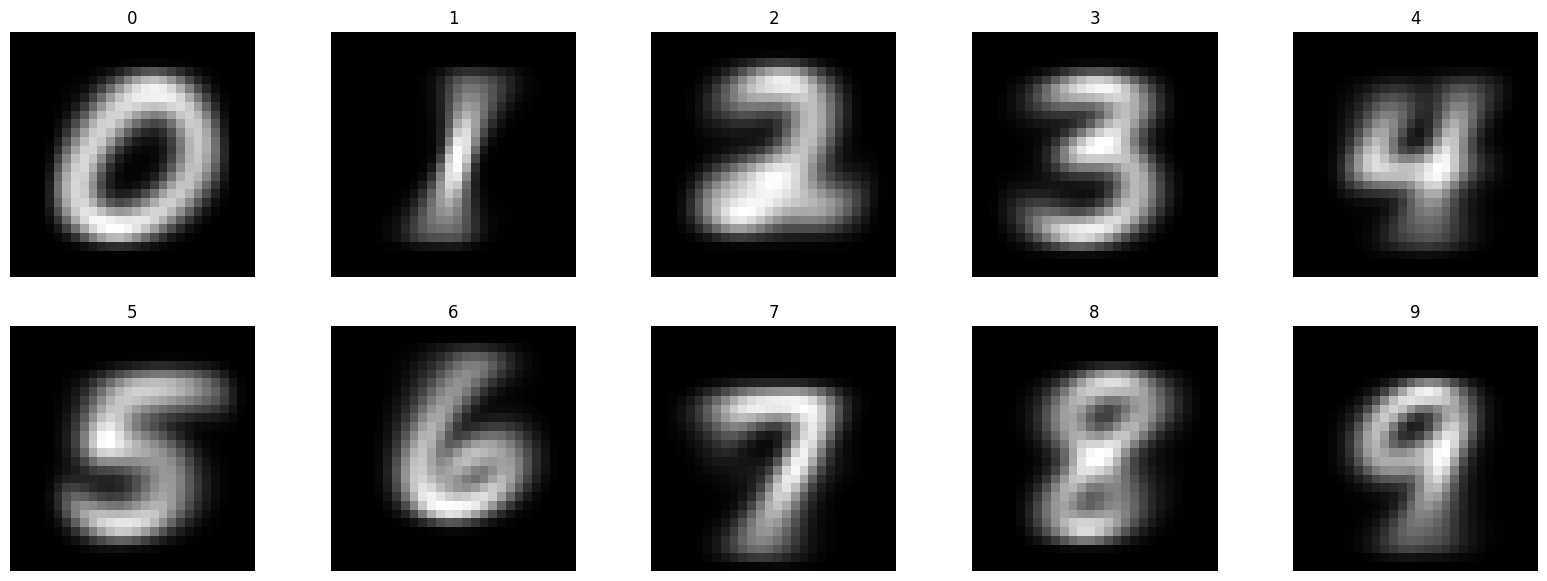

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

for idx in range(10):
    plt.subplot(2, 5, idx+1)
    plt.imshow(avg_imgs[idx], cmap='gray')
    plt.title(str(idx))
    plt.axis('off')

plt.show()

In [ ]:

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Create widgets
index_slider = widgets.IntSlider(value=0, min=0, max=9, step=1, description="Image Index:")
opacity_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description="Opacity:")

# Update function
def update(index, opacity):
    img1 = avg_imgs[index]
    img2 = model._weights[index].reshape((28, 28))

    # Resize if needed (optional)
    if img1.shape != img2.shape:
        print("Image shapes differ, resizing second image to match first.")
        from skimage.transform import resize
        img2 = resize(img2, img1.shape, anti_aliasing=True)

    # Normalize both images for display if needed
    img1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))
    img2 = (img2 - np.min(img2)) / (np.max(img2) - np.min(img2))

    # Blend the images
    blended = (1 - opacity) * img1 + opacity * img2

    plt.figure(figsize=(6, 6))
    plt.imshow(blended, cmap='seismic')
    plt.axis("off")
    plt.show()


# Link widgets to update function
widgets.interact(update, index=index_slider, opacity=opacity_slider)

interactive(children=(IntSlider(value=0, description='Image Index:', max=9), FloatSlider(value=0.5, descriptio…

<function __main__.update(index, opacity)>

## Conhecendo novas Métricas: Matrizes de Confusão, Precisão (Precision), Revocação (Recall) e F1-Score

A acurácia é uma métrica fácil para humanos compreenderem de como o classificador está comportamento. 

Contudo, como comentamos em aulas anteriores, ela possui algumas limitações: 

- Em bases altamente desbalanceadas, o classificador pode alcançar uma boa acurácia, mesmo tendo comportamentos indesejáveis. Por exemplo, em uma base em $90\%$ dos dados são de uma classe (e.g., $90\%$ de exames saudáveis vs. $10\%$ de exames não-saudáveis), se o classificador sempre responder esta classe (e.g., saudável), ele alcançará $90\%$ de acurácia. Parece um bom valor de acurácia, mas o classificador nunca irá responder a classe menos frequente. 

- Em problemas multiclasse, ela não informa se o erro está distribuído de forma uniforme em todas as classes ou se o classificador está com performance excelente em alguns casos e insatisfatória em outros. 


### Precisão, Revocação e F1-Score

#### Explicação Intuitiva

Vamos começar com uma definição intuitiva. Considere um problema de classificação binária em que o objetivo é saber se um exame possui uma doença ou não. 

Podemos definir a precisão (precision) e a revocação (recall) da seguinte forma: 

- **Revocação (Recall)**: dentre todos os exames doentes, qual percentual o classificador conseguiu identificar?
- **Precisão (Precision)**: dentre todos os exames que o classificador disse que eram doentes, quantos de fato estavam doentes?


#### Definição Precisa


Para chegar em uma definição precisa, vamos precisar introduzir alguns conceitos. 

A saída do modelo pode estar correta e isto acontece nos seguintes casos:

- **Verdadeiro Positivo (VP)**: O modelo previu que há doença, e isso está correto.
- **Verdadeiro Negativo (VN)**: O modelo previu que não há doença, e isso está correto.

A saída do modelo também pode estar errada e isto acontece nos seguintes casos:

- **Falso Positivo (FP)**: O modelo previu que há doença, mas isso está errado.
- **Falso Negativo (FN)**: O modelo previu que não há doença, mas isso está errado.

Em resumo:

| Situação real \ Previsão  | Doença (Positivo)        | Sem doença (Negativo)    |
| ------------------------- | ------------------------ | ------------------------ |
| **Doença (Positivo)**     | Verdadeiro Positivo (VP) | Falso Negativo (FN)      |
| **Sem doença (Negativo)** | Falso Positivo (FP)      | Verdadeiro Negativo (VN) |



Dados estes valores, as métricas podem ser calculadas como:

$$
\text{Precisão} = \frac{VP}{VP + FP}
$$

$$
\text{Revocação} = \frac{VP}{VP + FN}
$$

O F1-Score é uma média harmônica considerando a precisão e revocação. Ele tem como objetivo criar uma valor único que indique o `trade-off` entre elas.

$$
F_1 = 2 \cdot \frac{\text{Precisão} \cdot \text{Revocação}}{\text{Precisão} + \text{Revocação}}
$$


#### Implementação

Usando biblioteca, `scikit-learn`, podemos visualizar estas métricas usando a função `classification_report`. 

**Importante**: também existem funções para calcular as métricas separadamente. Para saber mais, veja a [documentação](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [15]:
from sklearn.metrics import classification_report

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.98      0.91      0.94       980
           1       0.94      0.92      0.93      1135
           2       0.95      0.69      0.80      1032
           3       0.79      0.88      0.83      1010
           4       0.95      0.71      0.81       982
           5       0.95      0.49      0.65       892
           6       0.92      0.92      0.92       958
           7       0.96      0.77      0.85      1028
           8       0.86      0.56      0.68       974
           9       0.72      0.90      0.80      1009

    accuracy                           0.78     10000
   macro avg       0.82      0.71      0.75     10000
weighted avg       0.90      0.78      0.82     10000



c:\Users\Windows\venv\venv_main\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Windows\venv\venv_main\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Windows\venv\venv_main\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Matriz de Confusão

A matriz de confusão mostra, em valor absoluto ou percentual, o número de itens de uma dada classe que foram classificados como sendo de outra classe.

O código abaixo mostra como produzir a matriz de confusão usando a biblioteca `scikit-learn`.

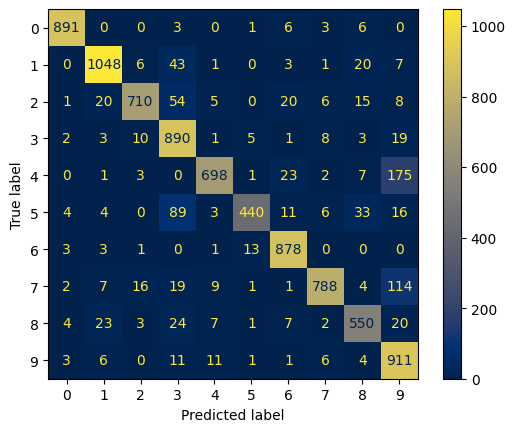

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, preds, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='cividis')
plt.show()


## Funções de Ativação

Ao invés da função degrau, podemos utilizar outras funções funções de ativação. Há na literatura várias outras que são comumente utilizadas em Redes Neurais Artificiais. Algumas delas são apresentadas a seguir e outras serão apresentadas ao longo da disciplina. 

A seguir, assuma que `net` é o resultado da operação linear realizada pelo neurônio, isto é, o produto interno entre pesos e entrada seguido da soma do bias.

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

x = np.arange(-5, 5, 0.1)


### Função identidade

Essa função simplesmente retorna o valor obtido após a etapa de combinação linear. 

$$f(net) = net$$

**Quando usar**: Esta função é utilizada quando deseja-se que a saída do neurônio seja um número real qualquer.

Text(0, 0.5, '$f(net)$')

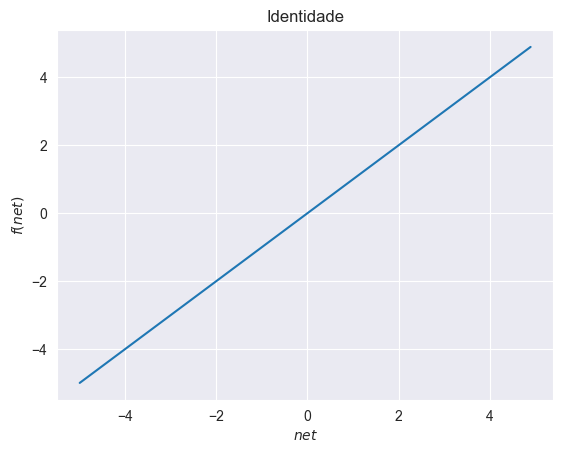

In [18]:
plt.title('Identidade')
plt.plot(x, x)
plt.xlabel(r'$net$')
plt.ylabel(r'$f(net)$')

### Sigmoid

A função *sigmoid* "compacta" ou "satura" sua entrada de modo que sua saída pertença ao intervalo $[0, 1]$. 

Ela é uma versão "soft" da função degrau.

Matematicamente, ela é dada por: 

$$f(net) = \frac{1}{1 + e^{-net}}.$$

Veja que quando $net = 0$, tem-se $f(net) = 0,5$. Isso implica que quando $net \le 0$, tem-se $f(net) \le 0,5$ e quando $net > 0$, tem-se $f(net) > 0,5$.

**Quando usar**: Esta função é utilizada quando deseja-se que a saída do neurônio represente uma probabilidade ou quando desejamos limitar a saída entre um valor mínimo e máximo.

Text(0, 0.5, '$f(net)$')

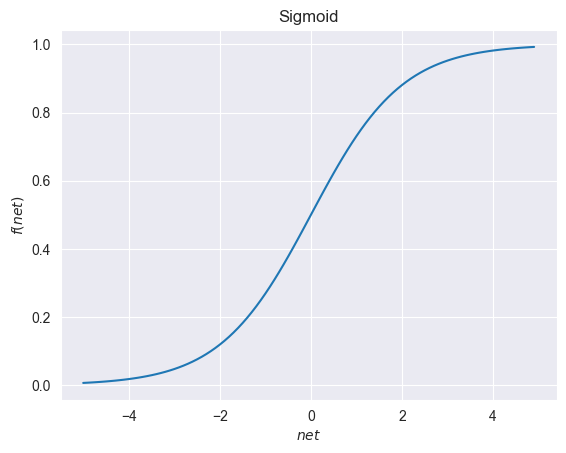

In [19]:
plt.title('Sigmoid')
plt.plot(x, 1 / (1 + np.exp(-x)))
plt.xlabel(r'$net$')
plt.ylabel(r'$f(net)$')

### Tangente hiperbólica

Possui um comportamento similar à função *sigmoid*. No entanto, ela "compacta" a entrada de forma a produzir uma saída no intervalo $[-1, 1]$. A função é definida da seguinte forma:

$$f(net) = \frac{e^{2net} - 1}{e^{2net} + 1}.$$

Veja que se $net \le 0$, então $f(net) \le 0$ e que se $net > 0$, então $f(net) > 0$.

Text(0, 0.5, '$f(net)$')

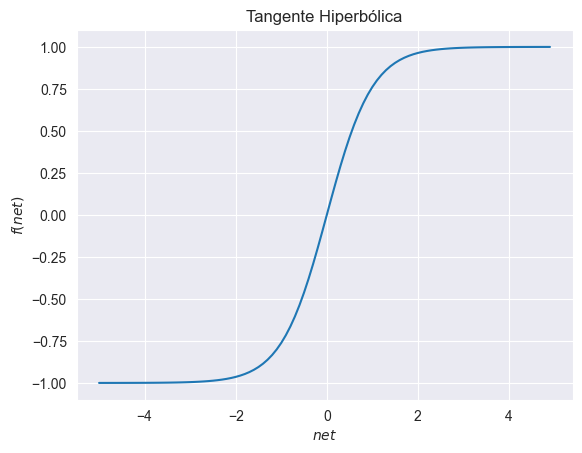

In [20]:
plt.title('Tangente Hiperbólica')
plt.plot(x, (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1))
plt.xlabel(r'$net$')
plt.ylabel(r'$f(net)$')

### *Rectified Linear Unit* (ReLU)

A unidade produz saída 0 se o resultado da combinação linear for menor que zero. 

Caso contrário, a função retorna o valor da combinação linear. 

Em outras palavras:

$$f(net) = \begin{cases}0, \text{ se } net \le 0\\ net,\text{ caso contrário.}\end{cases}$$

Uma outra representação da ReLU é dada por
$$f(net) = \max\{0, net\}.$$

Text(0, 0.5, '$f(net)$')

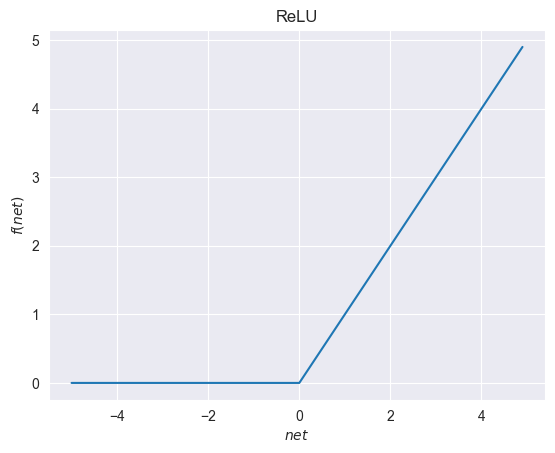

In [21]:
plt.title('ReLU')
plt.plot(x, np.maximum(0, x))
plt.xlabel(r'$net$')
plt.ylabel(r'$f(net)$')

A função ReLU é mais utilizada em redes neurais treinadas com descida de gradiente. Veremos a justificativa para isto mais à frente no curso.

### Softmax

A função softmax é utilizada para transformar a saída do modelo em probabilidades em uma tarefa multiclasse.

A expressão que define a função e o seu comportamento são ilustrados na figura abaixo.

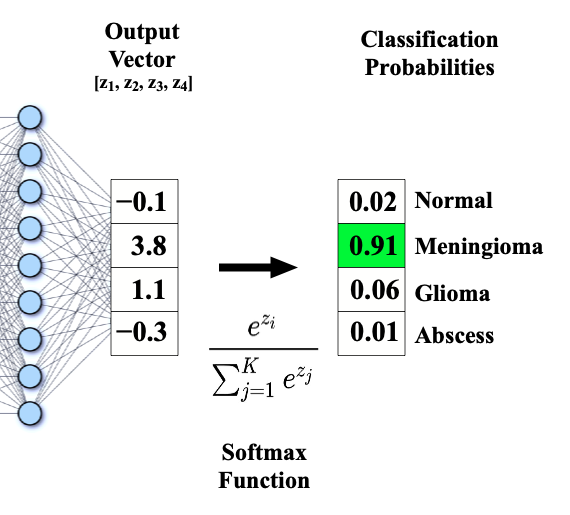

### Exemplos Práticos

In [22]:
def sigmoid(x):
    """
    Função sigmoid: sigma(x) = 1 / (1 + exp(-x))
    Pode ser usada com escalares, vetores ou matrizes NumPy.
    """
    return 1 / (1 + np.exp(-x))

def softmax(x):
    """
    Função softmax: softmax(x_i) = exp(x_i) / sum(exp(x))
    Suporta entrada 1D (vetor) ou 2D (matriz, onde aplica por linha).
    """
    x = np.array(x)
    if x.ndim == 1:
        e_x = np.exp(x - np.max(x))  # subtrai o max para estabilidade numérica
        return e_x / np.sum(e_x)
    elif x.ndim == 2:
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    else:
        raise ValueError("A entrada deve ser um vetor ou uma matriz.")

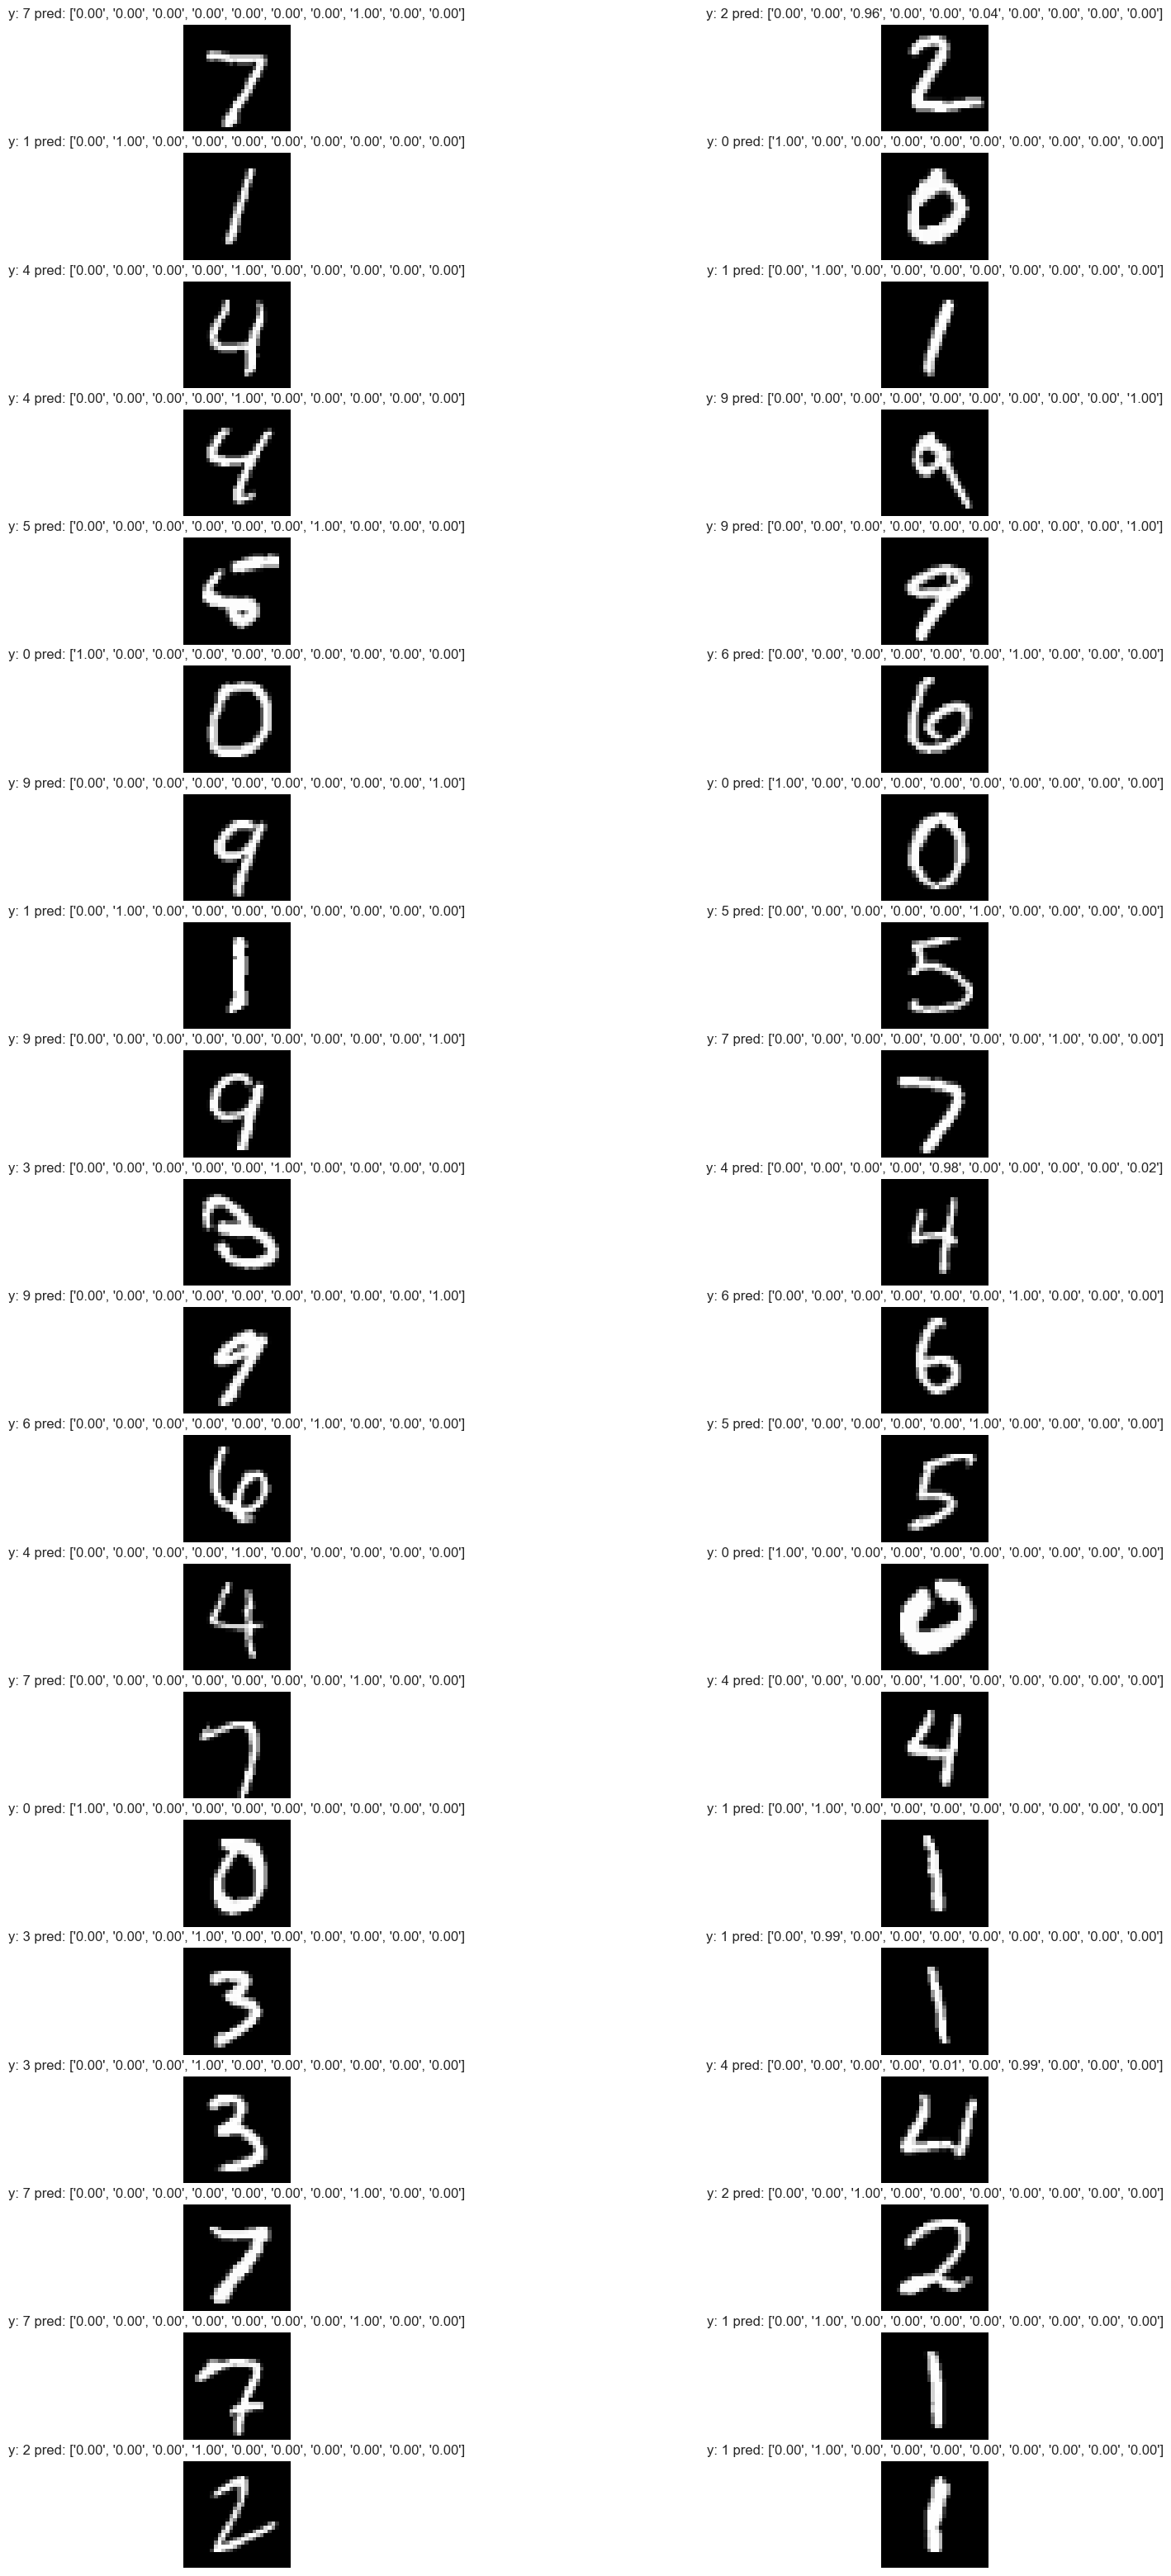

In [23]:
model._activation_fn = softmax

plt.figure(figsize=(20, 40))

for idx in range(40):
    plt.subplot(20, 2, idx+1)

    img = test_X[idx].reshape((28, 28))
    pred = model.forward(test_X[idx])
    s = [f"{p:.2f}" for p in pred]

    title = f"y: {test_y[idx]} pred: {s}"

    plt.imshow(img, cmap='gray')
    plt.title(title)

    plt.axis('off')

plt.show()

Acurácia usando a função softmax: 


In [25]:

preds = np.array([np.argmax(model.forward(x)) for x in test_X])
multiclass_accuracy(test_y, preds)


np.float64(0.8635)

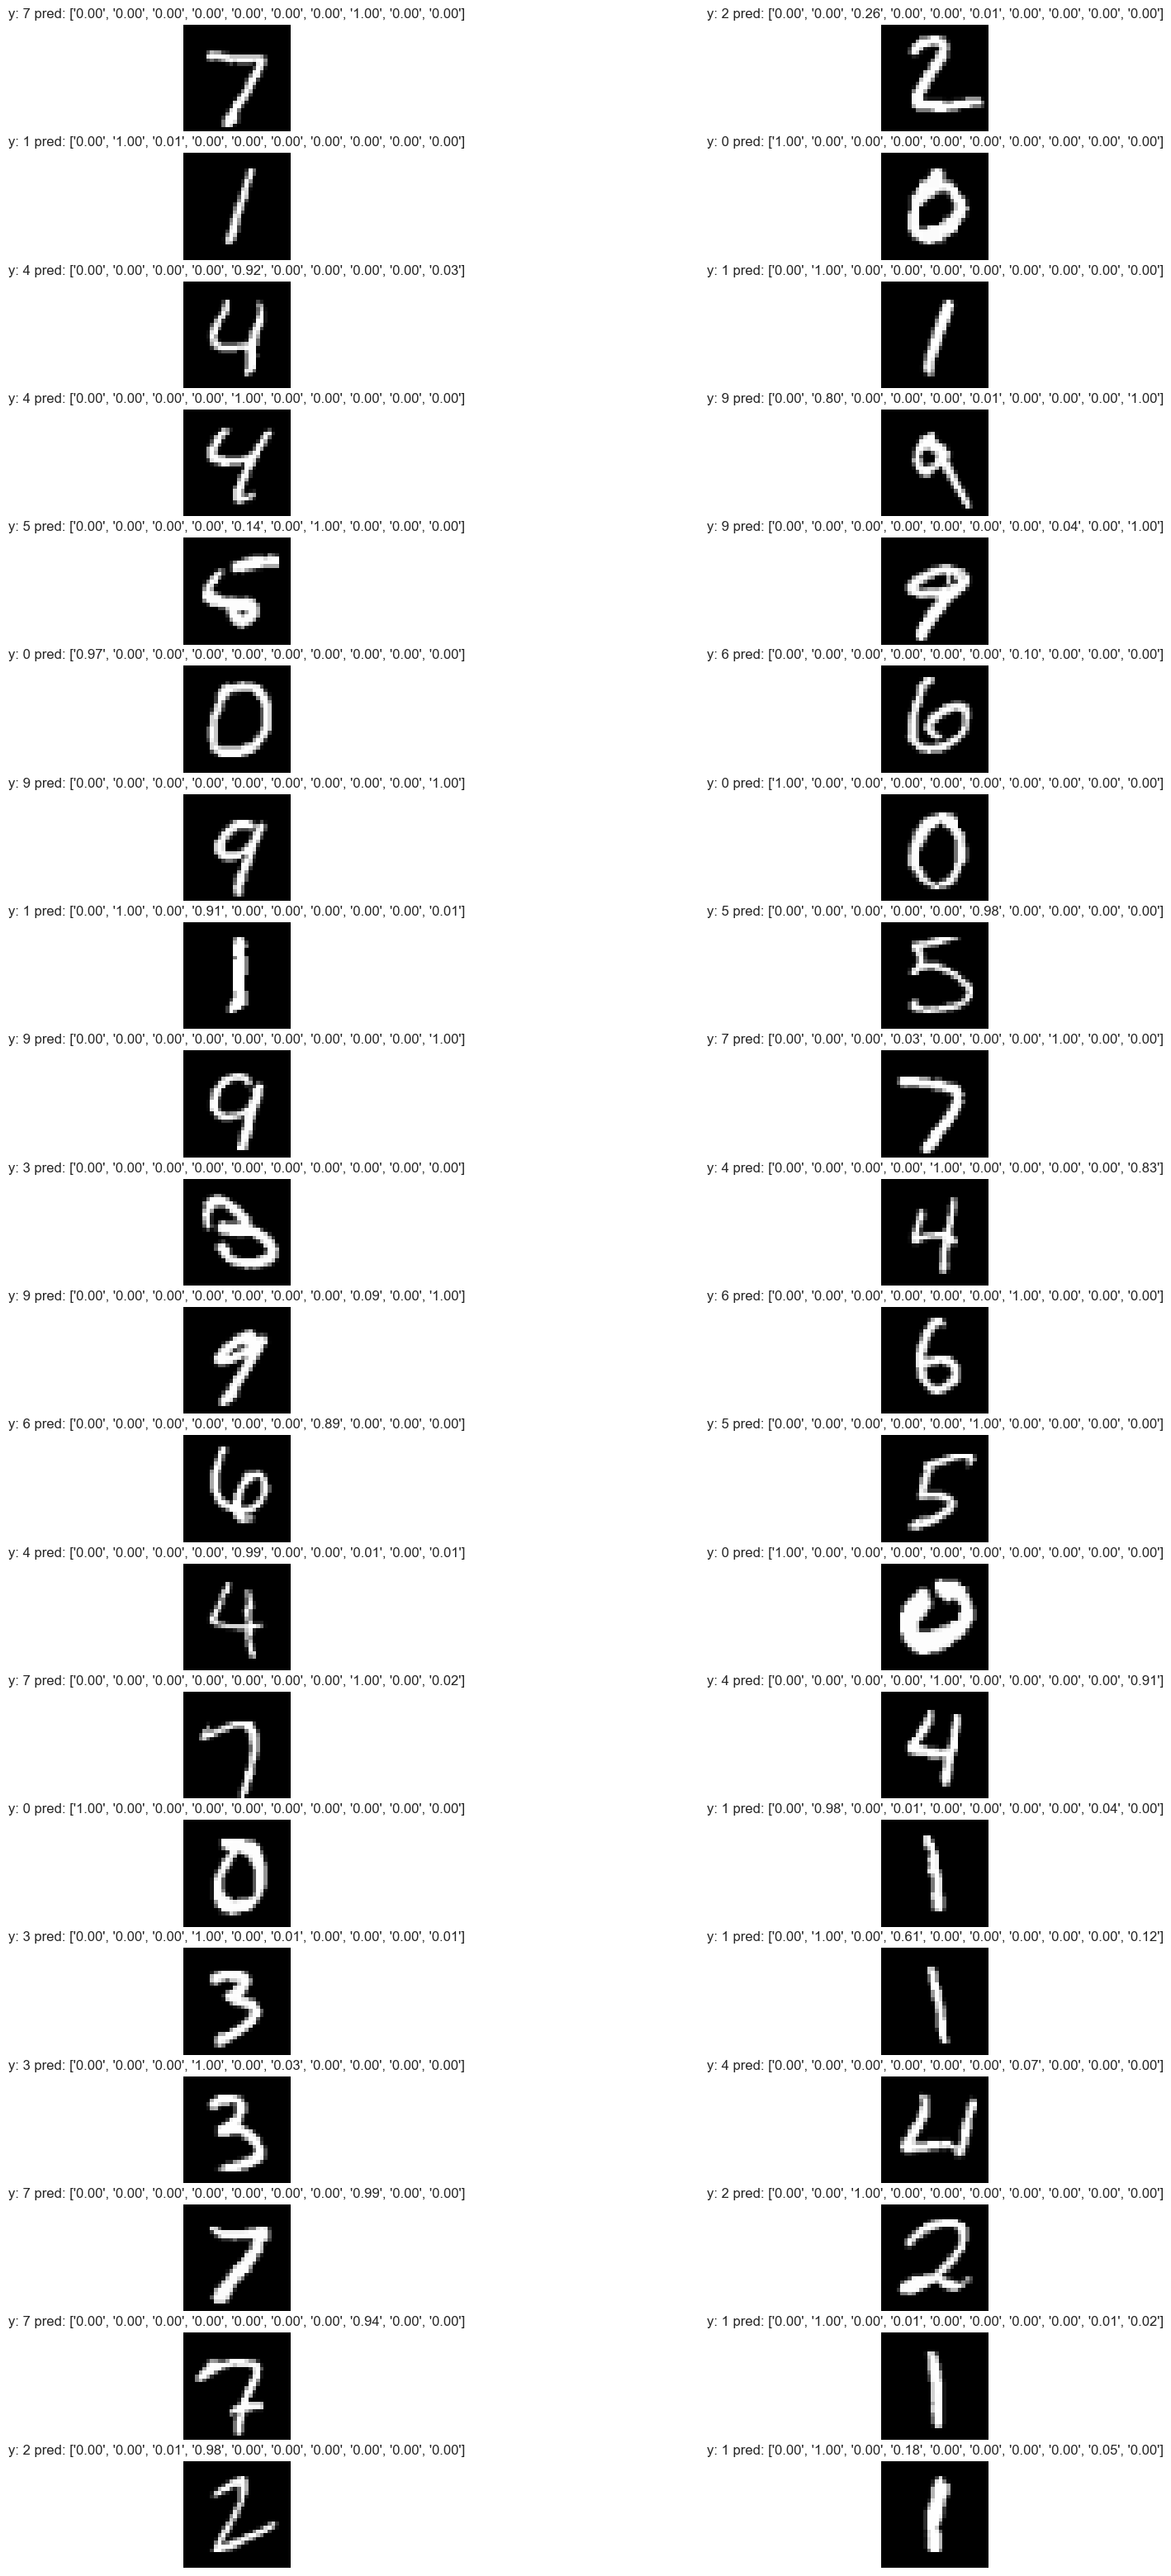

In [26]:
model._activation_fn = sigmoid

plt.figure(figsize=(20, 40))

for idx in range(40):
    plt.subplot(20, 2, idx+1)

    img = test_X[idx].reshape((28, 28))
    pred = model.forward(test_X[idx])
    s = [f"{p:.2f}" for p in pred]

    title = f"y: {test_y[idx]} pred: {s}"

    plt.imshow(img, cmap='gray')
    plt.title(title)

    plt.axis('off')

plt.show()

Acurácia usando a função Sigmóide:

In [ ]:

preds = np.array([np.argmax(model.forward(x)) for x in test_X])
multiclass_accuracy(test_y, preds)


np.float64(0.8635)